In [1]:
import math
import time
import pickle
from random import randint, random
from multiprocessing import Pool, TimeoutError

import numpy as np
import scipy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm as tqdm
from IPython.display import clear_output
from nfa_lib import NFA

sns.set()


In [10]:
nfa = NFA(
    states={'q0', 'q1', 'q2', 'q3', 'q4', 'q5', 'q6'},
    input_symbols={'0', '1'},
    transitions={
        'q0': {'0': {'q1'}, '1': {'q3'}},
        'q1': {'0': {'q2'}},
        'q2': {'0': {'q0'}, '1': {'q3'}},
        'q3': {'0': {'q4'}},
        'q4': {'0': {'q5'}},
        'q5': {'0': {'q3'}},
        'q6': {'1': {'q4'}},
    },
    initial_states={'q0', 'q1', 'q5', 'q6'},
    final_states={'q2', 'q4', 'q6'}
)

In [11]:
nfa.cycle_height()

[{'q4', 'q3', 'q5'}, {'q2', 'q0', 'q1'}, {'q6'}]
{'q2': {'q2': 0, 'q0': 1.0, 'q3': 1.0, 'q6': inf, 'q1': 2.0, 'q4': 2.0, 'q5': 3.0}, 'q6': {'q6': 0, 'q4': 1.0, 'q2': inf, 'q3': 3.0, 'q1': inf, 'q0': inf, 'q5': 2.0}, 'q3': {'q3': 0, 'q4': 1.0, 'q2': inf, 'q6': inf, 'q1': inf, 'q0': inf, 'q5': 2.0}, 'q1': {'q1': 0, 'q2': 1.0, 'q6': inf, 'q3': 2.0, 'q4': 3.0, 'q0': 2.0, 'q5': 4.0}, 'q4': {'q4': 0, 'q5': 1.0, 'q2': inf, 'q6': inf, 'q3': 2.0, 'q1': inf, 'q0': inf}, 'q0': {'q0': 0, 'q1': 1.0, 'q3': 1.0, 'q2': 2.0, 'q6': inf, 'q4': 2.0, 'q5': 3.0}, 'q5': {'q5': 0, 'q3': 1.0, 'q2': inf, 'q6': inf, 'q1': inf, 'q4': 2.0, 'q0': inf}}
[(1, 0), (2, 0)]
{0: defaultdict(<function floyd_warshall_predecessor_and_distance.<locals>.<lambda>.<locals>.<lambda> at 0x7f91c57d9160>, {0: 0, 1: inf, 2: inf}), 1: defaultdict(<function floyd_warshall_predecessor_and_distance.<locals>.<lambda>.<locals>.<lambda> at 0x7f91c57d90d0>, {1: 0, 0: 1, 2: inf}), 2: defaultdict(<function floyd_warshall_predecessor_and_dista

2

In [8]:
nfa = NFA(
    states={'q0', 'q1', 'q2', 'q3'},
    input_symbols={'0', '1'},
    transitions={
        'q0': {'0': {'q1', 'q2'}},
        'q1': {'0': {'q1', 'q3'}},
        'q2': {'0': {'q3'}, '1': {'q2'} },
        'q3': {'0': {'q3'}},
    },
    initial_states={'q0'},
    final_states={'q3'}
)

In [ ]:
nfa = NFA(
    states={'q0', 'q1', 'q2'},
    input_symbols={'0', '1'},
    transitions={
        'q0': {'0': {'q1'}},
        'q1': {'1': {'q2'}},
        'q2': {'1': {'q0'}}
    },
    initial_states={'q0'},
    final_states={'q1'}
)

In [13]:
%%time
nfa.bruteforce_count_only(20)

100%|██████████| 1048576/1048576 [00:06<00:00, 166056.87it/s]

CPU times: user 6.32 s, sys: 15.8 ms, total: 6.33 s
Wall time: 6.32 s


8

In [ ]:
nfa.plot()

In [2]:
def count_nfa(nfa: NFA, n: int, eps: float):
    nfa_unroll = nfa.unroll(n)
    return nfa_unroll.count_accepted(n=n, eps=eps), nfa_unroll

In [ ]:
count, nfa_unroll = count_nfa(nfa, 55, 1500)
count

In [ ]:
1 << 50

In [ ]:
189863754266 / 1e9

In [ ]:
nfa.accepts_input('')

In [ ]:
x = np.array([1.,2.,3.])


In [ ]:
print(nfa.plot().source)
nfa.plot()

# Experimentos estadísticos

In [ ]:
nfa = NFA(
    states={'q0', 'q1', 'q2'},
    input_symbols={'0', '1'},
    transitions={
        'q0': {'0': {'q1'}},
        # Use '' as the key name for empty string (lambda/epsilon) transitions
        'q1': {
            #'0': {'q1'},
            '1': {'q0', 'q2'}},
        'q2': {
            '1': {'q0'}
        }
    },
    initial_states={'q0'},
    final_states={'q1'}
)

In [21]:
%%time
data = [(i,nfa.bruteforce_count_only(i)) for i in range(1, 25)]

100%|██████████| 16777216/16777216 [01:49<00:00, 153658.04it/s]

CPU times: user 3min 32s, sys: 308 ms, total: 3min 32s
Wall time: 3min 32s


In [ ]:
log_data = [(i, math.log(max(1, nfa.bruteforce_count_only(i)))) for i in range(1, 20)]

In [22]:
df = pd.DataFrame(data, columns=["i", "frac"])

<AxesSubplot:xlabel='i'>

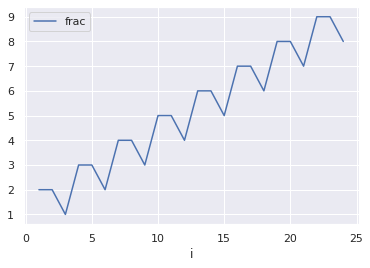

In [23]:
df.plot(x="i", y="frac")

In [20]:
df

,i,frac
0,1,2
1,2,2
2,3,1
3,4,3
4,5,3
5,6,2
6,7,4
7,8,4
8,9,3
9,10,5


In [ ]:
df[df.i >= 5].plot(x="i", y="frac")

In [ ]:
def fit_function(x, a, b, c):
    return a*b**(c*x)

In [ ]:
predictable_data = df[df.i.between(11,23)]

In [ ]:
x_data = predictable_data.i.values
y_data = predictable_data.frac.values
popt, pcov = scipy.optimize.curve_fit(fit_function, x_data, y_data, maxfev=1000)

In [ ]:
all_data = df[df.i >= 5]
all_x_data = all_data.i.values
all_y_data = all_data.frac.values

fig = plt.plot(all_x_data, fit_function(all_x_data, *popt), label="fit")
plt.plot(all_x_data, all_y_data, label="real")
plt.legend();
plt.title("Comparación valores predichos y reales")
plt.gcf().set_size_inches((14,8))

In [ ]:
plt.plot(all_x_data, fit_function(all_x_data, *popt) - all_y_data, label="fit")
plt.legend();
plt.title("Residuos")
plt.gcf().set_size_inches((14,8))

In [ ]:
k = 28
pred_for_k = fit_function(k, *popt) * 2**k
pred_for_k

In [ ]:
[(k,int(fit_function(k, *popt) * 2**k)) for k in range(6,28)]

In [ ]:
{{6, 13},
 {7, 23},
 {8, 44},
 {9, 81},
 {10, 148},
 {11, 274},
 {12, 504},
 {13, 927},
 {14, 1705}}

In [ ]:
%%time
ground_truth_k = nfa.bruteforce_dfs(k)
ground_truth_k

In [ ]:
popt

In [ ]:
# Error relativo!
(pred_for_k - ground_truth_k) / ground_truth_k

In [ ]:
# Error relativo!
(pred_for_k - ground_truth_k) / ground_truth_k

- https://arxiv.org/pdf/1802.04708.pdf -> si A es acíclico, el lenguaje es finito. De hecho, $L(A) \subseteq (\Sigma \cup \{\epsilon\})^{|Q|}$
- En general, para $n < |Q|$ el comportamiento se puede hardcodear, por lo que fuerza bruta o `sketch` son necesarios
- http://www.stringology.org/cgi-bin/getfile.cgi?t=pdf&c=-&y=2013&n=03 -> hay un algoritmo $O(|Q|)$ que usa `BFS` y `gcd` para determinar si la densidad del lenguaje es exponencial o polinomial. Se basa en encontrar dos caminos distintos del mismo largo y estado de partida en una componente fuertemente conexa (SCC).
    - Hipótesis 1: si el lenguaje tiene densidad exponencial, el gráfico $|L_n(A)|/2^n$ se verá como una constante tras al menos $n=|Q|$. Estimar es trivial para $n \gg |Q|$, basta retornar esa proporción multiplicada por $2^n$
    - Hipótesis 2: si el lenguaje tiene densidad polinomial, el gráfico $|L_n(A)|/2^n$ se verá como una exponencial
    decayendo. Se puede fittear una función y aproximar para $n \gg |Q|$
    
- [Scholar Kai Salomaa](https://scholar.google.com/citations?hl=es&user=N3AlqdYAAAAJ&view_op=list_works&sortby=pubdate)

Keeler, Salomaa


$|L(A)| \le \text{ambiguity} \le \text{string path width} \le \text{tree width}$

- **ambiguity**: number of accepting computations of A on a given string
- **string path width**: does not count partial computations, only complete (and maybe non-accepting) computations
- **tree width**: all computations of A on a given string (even partial ones)

In [ ]:
np.random.choice(["-1","0","1"], size=(3,3))[1,0]

In [ ]:
rand = NFA.random(n_states=5, input_symbols={"0", "1"}, sparsity=0.5)
rand.plot()

In [ ]:
rand.bruteforce_count_only(15)

In [ ]:
count, nfa_unroll = count_nfa(rand, 15, 100)
count

In [3]:
with open("intermediate_stats.pkl", "rb") as fd:
    results = pickle.load(fd)
        

In [ ]:
def compare_random_to_brute(i):
    print(f"[{i}] started\n", end="")
    retries = 100
    trial = 0
    need_finite_cycle_height = random() < 0.7
    while trial < retries:
        n_states = randint(6, 16)
        rand = NFA.random(n_states=n_states, input_symbols={"0", "1"}, sparsity=0.4)
        if need_finite_cycle_height:
            c_height = rand.cycle_height()
            if c_height == float("inf") or c_height < .5:
                trial += 1
                continue
        string_len = randint(4, 10)
        epsilon = randint(4 * string_len, 12 * string_len)
        # print(f"[{i}] bruteforce started\n", end="")
        
        bruteforce = rand.bruteforce_count_only(string_len)
        if bruteforce == 0:
            # print(f"[{i}] insufficient accepting strings")
            trial += 1
            continue
        break
    if trial >= retries:
        return 0
    try:
        t0 = time.time()
        count, nfa_unroll = count_nfa(rand, string_len, epsilon)
        t1 = time.time()
        return [
            n_states,
            rand.initial_states,
            rand.final_states,
            rand.transitions,
            string_len,
            bruteforce,
            count,
            epsilon,
            t1 - t0,
        ]
    except Exception as e:
        return e


# results = [] # n_states, initial_states, final_states, transitions, string_n, bruteforce, estimate, eps, time
samples = 0
errors = []
error_count = 0
n_proc = 6
with Pool(processes=n_proc) as pool:
    while samples < 50000 and error_count < 300:
        multiproc_results = [pool.apply_async(compare_random_to_brute, (i,)) for i in range(100)]
        for res_promise in tqdm(multiproc_results):
            res = None
            try:
                res = res_promise.get(timeout=240)
            except TimeoutError:
                continue

            if isinstance(res, Exception):
                errors.append(res)
                error_count += 1
                continue
            else:
                samples += 1
                if res != 0:
                    results.append(res)

        clear_output(wait=True)
        with open("intermediate_stats.pkl", "wb") as fd:
            pickle.dump(results, fd)
        print(f"Wrote pickle file for {len(results)} results")


[0] started
[1] started
Wrote pickle file for 469 results


  0%|          | 0/100 [00:00<?, ?it/s]

[3] started
[2] started
[4] started
[5] started
[6] started
[7] started
[8] started
[9] started


  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

Unreachable state ('q0', 0) was removed
Unreachable state ('q0', 0) was removedUnreachable state ('q1', 0) was removed
Unreachable state ('q0', 1) was removed
Unreachable state ('q1', 0) was removed
Unreachable state ('q1', 1) was removed
Unreachable state ('q2', 0) was removed
Unreachable state ('q3', 0) was removed
Unreachable state ('q3', 1) was removed
Unreachable state ('q5', 0) was removed

Unreachable state ('q5', 1) was removedUnreachable state ('q2', 0) was removed

Unreachable state ('q6', 0) was removedUnreachable state ('q3', 0) was removed

Unreachable state ('q4', 0) was removed
Unreachable state ('q5', 0) was removed
Unreachable state ('q6', 0) was removed
Retries per sample 162229
Sample size Unreachable state ('q7', 0) was removed128
Unreachable state ('q8', 0) was removed
Unreachable state ('q9', 0) was removed
Unreachable state ('q10', 0) was removed
Unreachable state ('q10', 1) was removed

Unreachable state ('q11', 0) was removed
Unreachable state ('q11', 1) was re

Layer:   0%|          | 0/7 [00:00<?, ?it/s]

Sample size 128


State at layer 1:   0%|          | 0/8 [00:00<?, ?it/s]

Layer:   0%|          | 0/8 [00:00<?, ?it/s]

State at layer 1:   0%|          | 0/6 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

State at layer 2:   0%|          | 0/12 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

State at layer 2:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

State at layer 3:   0%|          | 0/12 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

State at layer 3:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

State at layer 4:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

State at layer 4:   0%|          | 0/12 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

State at layer 5:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

State at layer 10:   0%|          | 0/12 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

State at layer 6:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

State at layer 5:   0%|          | 0/12 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

State at layer 7:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

State at layer 6:   0%|          | 0/12 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

[10] started
[11] started


  0%|          | 0/32 [00:00<?, ?it/s]

Unreachable state ('q0', 0) was removed
Unreachable state ('q1', 1) was removed
Unreachable state ('q2', 0) was removed
Unreachable state ('q3', 0) was removed
Unreachable state ('q4', 0) was removed
Unreachable state ('q5', 0) was removed
Unreachable state ('q5', 1) was removed
Unreachable state ('q6', 0) was removed
Unreachable state ('q7', 0) was removed
Unreachable state ('q8', 0) was removed
Unreachable state ('q8', 1) was removed
Retries per sample 143581
Sample size 72


Layer:   0%|          | 0/5 [00:00<?, ?it/s]

State at layer 1:   0%|          | 0/6 [00:00<?, ?it/s]

Sampling:   0%|          | 0/72 [00:00<?, ?it/s]

Sampling:   0%|          | 0/72 [00:00<?, ?it/s]

Sampling:   0%|          | 0/72 [00:00<?, ?it/s]

Sampling:   0%|          | 0/72 [00:00<?, ?it/s]

Sampling:   0%|          | 0/72 [00:00<?, ?it/s]

Sampling:   0%|          | 0/72 [00:00<?, ?it/s]

State at layer 2:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling:   0%|          | 0/72 [00:00<?, ?it/s]

Sampling:   0%|          | 0/72 [00:00<?, ?it/s]

Sampling:   0%|          | 0/72 [00:00<?, ?it/s]

Sampling:   0%|          | 0/72 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/72 [00:00<?, ?it/s]

Sampling:   0%|          | 0/72 [00:00<?, ?it/s]

Sampling:   0%|          | 0/72 [00:00<?, ?it/s]

Sampling:   0%|          | 0/72 [00:00<?, ?it/s]

Sampling:   0%|          | 0/72 [00:00<?, ?it/s]

State at layer 3:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling:   0%|          | 0/72 [00:00<?, ?it/s]

Sampling:   0%|          | 0/72 [00:00<?, ?it/s]

Sampling:   0%|          | 0/72 [00:00<?, ?it/s]

Sampling:   0%|          | 0/72 [00:00<?, ?it/s]

Sampling:   0%|          | 0/72 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/72 [00:00<?, ?it/s]

Sampling:   0%|          | 0/72 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/72 [00:00<?, ?it/s]

Sampling:   0%|          | 0/72 [00:00<?, ?it/s]

State at layer 4:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling:   0%|          | 0/72 [00:00<?, ?it/s]

Sampling:   0%|          | 0/72 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/72 [00:00<?, ?it/s]

Sampling:   0%|          | 0/72 [00:00<?, ?it/s]

Sampling:   0%|          | 0/72 [00:00<?, ?it/s]

Sampling:   0%|          | 0/72 [00:00<?, ?it/s]

Sampling:   0%|          | 0/72 [00:00<?, ?it/s]

Sampling:   0%|          | 0/72 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/72 [00:00<?, ?it/s]

State at layer 5:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling:   0%|          | 0/72 [00:00<?, ?it/s]

Sampling:   0%|          | 0/72 [00:00<?, ?it/s]

Sampling:   0%|          | 0/72 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/72 [00:00<?, ?it/s]

Sampling:   0%|          | 0/72 [00:00<?, ?it/s]

Sampling:   0%|          | 0/72 [00:00<?, ?it/s]

Sampling:   0%|          | 0/72 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/72 [00:00<?, ?it/s]

Sampling:   0%|          | 0/72 [00:00<?, ?it/s]

[12] started


  0%|          | 0/64 [00:00<?, ?it/s]

Unreachable state ('q0', 0) was removed
Unreachable state ('q1', 0) was removed
Unreachable state ('q3', 0) was removed
Unreachable state ('q4', 0) was removed
Unreachable state ('q6', 0) was removed
Unreachable state ('q6', 1) was removed
Retries per sample 153573
Sample size 98


Layer:   0%|          | 0/6 [00:00<?, ?it/s]

State at layer 1:   0%|          | 0/6 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

State at layer 2:   0%|          | 0/7 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

State at layer 3:   0%|          | 0/7 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

State at layer 4:   0%|          | 0/7 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

State at layer 5:   0%|          | 0/7 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

State at layer 7:   0%|          | 0/12 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

State at layer 6:   0%|          | 0/7 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

[13] started


  0%|          | 0/32 [00:00<?, ?it/s]

Unreachable state ('q0', 0) was removed
Unreachable state ('q1', 0) was removed
Unreachable state ('q2', 0) was removed
Unreachable state ('q3', 0) was removed
Unreachable state ('q5', 0) was removed
Unreachable state ('q6', 0) was removed
Unreachable state ('q6', 1) was removed
Unreachable state ('q7', 0) was removed
Unreachable state ('q8', 0) was removed
Unreachable state ('q8', 1) was removed
Unreachable state ('q9', 0) was removed
Unreachable state ('q9', 1) was removed
Unreachable state ('q10', 0) was removed
Unreachable state ('q11', 0) was removed
Unreachable state ('q12', 0) was removed
Unreachable state ('q12', 1) was removed
Retries per sample 176693
Sample size 200


Layer:   0%|          | 0/5 [00:00<?, ?it/s]

State at layer 1:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

State at layer 2:   0%|          | 0/13 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

State at layer 3:   0%|          | 0/13 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

State at layer 8:   0%|          | 0/12 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

State at layer 4:   0%|          | 0/13 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

[14] started


  0%|          | 0/32 [00:00<?, ?it/s]

Unreachable state ('q0', 0) was removed
Unreachable state ('q1', 0) was removed
Unreachable state ('q4', 0) was removed
Unreachable state ('q5', 0) was removed
Unreachable state ('q6', 0) was removed
Unreachable state ('q7', 0) was removed
Unreachable state ('q8', 0) was removed
Unreachable state ('q9', 0) was removed
Unreachable state ('q10', 0) was removed
Unreachable state ('q11', 0) was removed
Unreachable state ('q14', 0) was removed
Unreachable state ('q15', 0) was removed
Retries per sample 211089
Sample size 578


Layer:   0%|          | 0/5 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

State at layer 1:   0%|          | 0/16 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

State at layer 2:   0%|          | 0/16 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

State at layer 5:   0%|          | 0/13 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

[15] started


  0%|          | 0/512 [00:00<?, ?it/s]

Unreachable state ('q0', 0) was removed
Unreachable state ('q1', 0) was removed
Unreachable state ('q2', 0) was removed
Unreachable state ('q3', 0) was removed
Unreachable state ('q3', 1) was removed
Unreachable state ('q4', 0) was removed
Unreachable state ('q6', 0) was removed
Unreachable state ('q7', 0) was removed
Unreachable state ('q8', 0) was removed
Unreachable state ('q9', 0) was removed
Unreachable state ('q10', 0) was removed
Unreachable state ('q11', 0) was removed
Unreachable state ('q13', 0) was removed
Retries per sample 202976Sample size
 450


Layer:   0%|          | 0/9 [00:00<?, ?it/s]

State at layer 1:   0%|          | 0/13 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

State at layer 2:   0%|          | 0/14 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

State at layer 3:   0%|          | 0/14 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

State at layer 3:   0%|          | 0/16 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

State at layer 7:   0%|          | 0/11 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

State at layer 4:   0%|          | 0/14 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

[16] started
[17] started


  0%|          | 0/32 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Unreachable state ('q0', 0) was removed
Unreachable state ('q0', 1) was removed
Unreachable state ('q1', 0) was removed
Unreachable state ('q1', 1) was removed
Unreachable state ('q2', 0) was removed
Unreachable state ('q3', 0) was removed
Unreachable state ('q3', 1) was removed
Unreachable state ('q4', 0) was removed
Unreachable state ('q5', 0) was removed
Unreachable state ('q6', 0) was removed
Unreachable state ('q7', 0) was removed
Unreachable state ('q7', 1) was removed
Unreachable state ('q8', 0) was removed
Unreachable state ('q9', 0) was removed
Unreachable state ('q9', 1) was removed
Unreachable state ('q11', 0) was removed
Unreachable state ('q12', 0) was removed
Unreachable state ('q13', 0) was removed
Retries per sample 211089
Sample size 578


Layer:   0%|          | 0/5 [00:00<?, ?it/s]

State at layer 1:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

State at layer 2:   0%|          | 0/14 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

State at layer 3:   0%|          | 0/14 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

[18] started
[19] started
[20] started


  0%|          | 0/16 [00:00<?, ?it/s]

Unreachable state ('q0', 0) was removed
Unreachable state ('q1', 0) was removed
Unreachable state ('q2', 0) was removed
Unreachable state ('q2', 1) was removed
Unreachable state ('q3', 0) was removed
Unreachable state ('q4', 0) was removed
Unreachable state ('q5', 0) was removed
Unreachable state ('q7', 0) was removed
Unreachable state ('q8', 0) was removed
Unreachable state ('q9', 0) was removed
Unreachable state ('q10', 0) was removed
Retries per sample 169864
Sample size 162


Layer:   0%|          | 0/4 [00:00<?, ?it/s]

State at layer 1:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling:   0%|          | 0/162 [00:00<?, ?it/s]

Sampling:   0%|          | 0/162 [00:00<?, ?it/s]

Sampling:   0%|          | 0/162 [00:00<?, ?it/s]

Sampling:   0%|          | 0/162 [00:00<?, ?it/s]

Sampling:   0%|          | 0/162 [00:00<?, ?it/s]

Sampling:   0%|          | 0/162 [00:00<?, ?it/s]

Sampling:   0%|          | 0/162 [00:00<?, ?it/s]

Sampling:   0%|          | 0/162 [00:00<?, ?it/s]

Sampling:   0%|          | 0/162 [00:00<?, ?it/s]

Sampling:   0%|          | 0/162 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

State at layer 2:   0%|          | 0/11 [00:00<?, ?it/s]

Sampling:   0%|          | 0/162 [00:00<?, ?it/s]

Sampling:   0%|          | 0/162 [00:00<?, ?it/s]

Sampling:   0%|          | 0/162 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/162 [00:00<?, ?it/s]

Sampling:   0%|          | 0/162 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/162 [00:00<?, ?it/s]

Sampling:   0%|          | 0/162 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/162 [00:00<?, ?it/s]

Sampling:   0%|          | 0/162 [00:00<?, ?it/s]

Sampling:   0%|          | 0/162 [00:00<?, ?it/s]

Sampling:   0%|          | 0/162 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

State at layer 3:   0%|          | 0/11 [00:00<?, ?it/s]

Sampling:   0%|          | 0/162 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/162 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/162 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/162 [00:00<?, ?it/s]

Sampling:   0%|          | 0/162 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/162 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/162 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/162 [00:00<?, ?it/s]

Sampling:   0%|          | 0/162 [00:00<?, ?it/s]

State at layer 4:   0%|          | 0/16 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/162 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/162 [00:00<?, ?it/s]

State at layer 4:   0%|          | 0/11 [00:00<?, ?it/s]

Sampling:   0%|          | 0/162 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/162 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/162 [00:00<?, ?it/s]

State at layer 5:   0%|          | 0/14 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/162 [00:00<?, ?it/s]

State at layer 8:   0%|          | 0/11 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/162 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/162 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/162 [00:00<?, ?it/s]

Sampling:   0%|          | 0/162 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/162 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/162 [00:00<?, ?it/s]

Sampling:   0%|          | 0/162 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

[21] started
[22] started
[23] started


Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

[24] started
[25] started


  0%|          | 0/256 [00:00<?, ?it/s]

Unreachable state ('q1', 0) was removed
Unreachable state ('q2', 0) was removed
Unreachable state ('q3', 0) was removed
Unreachable state ('q3', 1) was removed
Unreachable state ('q4', 0) was removed
Unreachable state ('q5', 0) was removed
Retries per sample 131763
Sample size 50


Layer:   0%|          | 0/8 [00:00<?, ?it/s]

State at layer 1:   0%|          | 0/5 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

State at layer 2:   0%|          | 0/6 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

State at layer 3:   0%|          | 0/6 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

State at layer 4:   0%|          | 0/6 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

State at layer 5:   0%|          | 0/6 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

State at layer 6:   0%|          | 0/6 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

State at layer 7:   0%|          | 0/6 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

State at layer 8:   0%|          | 0/6 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

[26] started
[27] started


  0%|          | 0/1024 [00:00<?, ?it/s]

Unreachable state ('q1', 0) was removed
Unreachable state ('q2', 0) was removed
Unreachable state ('q3', 0) was removed
Unreachable state ('q4', 1) was removed
Unreachable state ('q5', 0) was removed
Retries per sample 162229
Sample size 128


Layer:   0%|          | 0/10 [00:00<?, ?it/s]

State at layer 1:   0%|          | 0/6 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

State at layer 2:   0%|          | 0/7 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

State at layer 3:   0%|          | 0/7 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

State at layer 4:   0%|          | 0/7 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

State at layer 5:   0%|          | 0/7 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

State at layer 6:   0%|          | 0/7 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

State at layer 4:   0%|          | 0/14 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

State at layer 7:   0%|          | 0/7 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

State at layer 6:   0%|          | 0/14 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

State at layer 8:   0%|          | 0/7 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

State at layer 5:   0%|          | 0/16 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

State at layer 9:   0%|          | 0/7 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

State at layer 10:   0%|          | 0/7 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

State at layer 7:   0%|          | 0/14 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

State at layer 5:   0%|          | 0/14 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

State at layer 8:   0%|          | 0/11 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

[28] started


Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

[29] started


  0%|          | 0/512 [00:00<?, ?it/s]

Unreachable state ('q1', 0) was removed
Unreachable state ('q2', 0) was removed
Unreachable state ('q3', 0) was removed
Unreachable state ('q5', 0) was removed
Unreachable state ('q6', 0) was removed
Unreachable state ('q7', 0) was removed
Retries per sample 218299
Sample size 722


Layer:   0%|          | 0/9 [00:00<?, ?it/s]

State at layer 1:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

[30] started


  0%|          | 0/16 [00:00<?, ?it/s]

Unreachable state ('q0', 0) was removed
Unreachable state ('q1', 0) was removed
Unreachable state ('q2', 0) was removed
Unreachable state ('q3', 1) was removed
Unreachable state ('q4', 0) was removed
Unreachable state ('q5', 0) was removed
Unreachable state ('q6', 0) was removed
Unreachable state ('q6', 1) was removed
Unreachable state ('q7', 0) was removed
Unreachable state ('q8', 0) was removed
Unreachable state ('q8', 1) was removed
Unreachable state ('q9', 0) was removed
Unreachable state ('q9', 1) was removed
Unreachable state ('q10', 0) was removed
Unreachable state ('q10', 1) was removed
Unreachable state ('q11', 0) was removed
Unreachable state ('q11', 1) was removed
Retries per sample 176693
Sample size 200


Layer:   0%|          | 0/4 [00:00<?, ?it/s]

State at layer 1:   0%|          | 0/6 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

State at layer 2:   0%|          | 0/12 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

State at layer 2:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

State at layer 3:   0%|          | 0/12 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

State at layer 3:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

State at layer 4:   0%|          | 0/12 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

State at layer 4:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

[31] started
[32] started


  0%|          | 0/32 [00:00<?, ?it/s]

Unreachable state ('q0', 0) was removed
Unreachable state ('q1', 0) was removed
Unreachable state ('q4', 0) was removed
Unreachable state ('q6', 0) was removed
Retries per sample 176693
Sample size 200


Layer:   0%|          | 0/5 [00:00<?, ?it/s]

State at layer 1:   0%|          | 0/7 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

State at layer 2:   0%|          | 0/7 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

State at layer 3:   0%|          | 0/7 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

State at layer 8:   0%|          | 0/14 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

State at layer 4:   0%|          | 0/7 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

State at layer 5:   0%|          | 0/7 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

State at layer 5:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

[33] started
[34] started


  0%|          | 0/512 [00:00<?, ?it/s]

Unreachable state ('q0', 1) was removed
Unreachable state ('q1', 0) was removed
Unreachable state ('q1', 1) was removed
Unreachable state ('q2', 0) was removed
Unreachable state ('q3', 0) was removed
Unreachable state ('q4', 0) was removed
Unreachable state ('q5', 0) was removed
Unreachable state ('q6', 0) was removed
Unreachable state ('q6', 1) was removed
Unreachable state ('q7', 0) was removed
Unreachable state ('q7', 1) was removed
Unreachable state ('q8', 0) was removed
Unreachable state ('q9', 0) was removed
Unreachable state ('q10', 0) was removed
Unreachable state ('q11', 0) was removed
Unreachable state ('q12', 0) was removed
Unreachable state ('q13', 0) was removed
Unreachable state ('q14', 0) was removed
Retries per sample 247906
Sample size 1800


Layer:   0%|          | 0/9 [00:00<?, ?it/s]

State at layer 1:   0%|          | 0/11 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

State at layer 2:   0%|          | 0/15 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1800 [00:00<?, ?it/s]

State at layer 6:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

State at layer 3:   0%|          | 0/15 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

State at layer 7:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/578 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

State at layer 9:   0%|          | 0/14 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

State at layer 9:   0%|          | 0/11 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

[35] started
[36] started
[37] started
[38] started
[39] started
[40] started


  0%|          | 0/256 [00:00<?, ?it/s]

Unreachable state ('q0', 0) was removed
Unreachable state ('q1', 0) was removed
Unreachable state ('q1', 1) was removed
Unreachable state ('q2', 0) was removed
Unreachable state ('q2', 1) was removed
Unreachable state ('q3', 0) was removed
Unreachable state ('q3', 1) was removed
Unreachable state ('q4', 0) was removed
Unreachable state ('q5', 0) was removed
Unreachable state ('q6', 0) was removed
Unreachable state ('q7', 0) was removed
Unreachable state ('q8', 0) was removed
Unreachable state ('q9', 0) was removed
Unreachable state ('q10', 0) was removed
Unreachable state ('q11', 0) was removed
Retries per sample 176693
Sample size 200


Layer:   0%|          | 0/8 [00:00<?, ?it/s]

State at layer 1:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

State at layer 2:   0%|          | 0/13 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

State at layer 3:   0%|          | 0/13 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

State at layer 8:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

State at layer 4:   0%|          | 0/13 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

State at layer 5:   0%|          | 0/13 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

State at layer 9:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

State at layer 6:   0%|          | 0/13 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/450 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

[41] started


  0%|          | 0/64 [00:00<?, ?it/s]

Unreachable state ('q0', 0) was removed
Unreachable state ('q2', 0) was removed
Unreachable state ('q3', 0) was removed
Unreachable state ('q4', 0) was removed
Unreachable state ('q4', 1) was removed
Unreachable state ('q5', 0) was removed
Unreachable state ('q6', 0) was removed
Unreachable state ('q8', 0) was removed
Unreachable state ('q9', 0) was removed
Unreachable state ('q9', 1) was removed
Unreachable state ('q10', 0) was removed
Unreachable state ('q10', 1) was removed
Unreachable state ('q11', 0) was removed
Unreachable state ('q12', 0) was removed
Retries per sample 176693
Sample size 200


Layer:   0%|          | 0/6 [00:00<?, ?it/s]

State at layer 1:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

State at layer 2:   0%|          | 0/13 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

State at layer 3:   0%|          | 0/13 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/722 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

[42] started
[43] started


  0%|          | 0/1024 [00:00<?, ?it/s]

Unreachable state ('q0', 0) was removed
Unreachable state ('q1', 0) was removed
Unreachable state ('q2', 0) was removed
Unreachable state ('q2', 1) was removed
Unreachable state ('q2', 2) was removed
Unreachable state ('q3', 0) was removed
Unreachable state ('q3', 1) was removed
Unreachable state ('q4', 0) was removed
Unreachable state ('q5', 1) was removed
Unreachable state ('q6', 0) was removed
Unreachable state ('q7', 0) was removed
Unreachable state ('q7', 1) was removed
Unreachable state ('q8', 0) was removed
Unreachable state ('q8', 1) was removed
Retries per sample 162229
Sample size 128


Layer:   0%|          | 0/10 [00:00<?, ?it/s]

State at layer 1:   0%|          | 0/4 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

State at layer 2:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

State at layer 3:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

State at layer 4:   0%|          | 0/15 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

State at layer 4:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

[44] started
[45] started


  0%|          | 0/1024 [00:00<?, ?it/s]

Unreachable state ('q0', 0) was removed
Unreachable state ('q1', 0) was removed
Unreachable state ('q2', 0) was removed
Unreachable state ('q3', 0) was removed
Unreachable state ('q3', 1) was removed
Unreachable state ('q4', 0) was removed
Unreachable state ('q5', 0) was removed
Unreachable state ('q6', 0) was removed
Retries per sample 162229
Sample size 128


Layer:   0%|          | 0/10 [00:00<?, ?it/s]

State at layer 1:   0%|          | 0/7 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

State at layer 2:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

State at layer 3:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

State at layer 4:   0%|          | 0/13 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

State at layer 4:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

State at layer 5:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

State at layer 5:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

State at layer 7:   0%|          | 0/13 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

State at layer 6:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

State at layer 6:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

State at layer 7:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

State at layer 7:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1800 [00:00<?, ?it/s]

State at layer 5:   0%|          | 0/13 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

State at layer 8:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

State at layer 8:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

State at layer 9:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

State at layer 10:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

State at layer 9:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

State at layer 6:   0%|          | 0/13 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

[46] started
[47] started


  0%|          | 0/32 [00:00<?, ?it/s]

Unreachable state ('q0', 1) was removed
Unreachable state ('q1', 0) was removed
Unreachable state ('q1', 1) was removed
Unreachable state ('q2', 0) was removed
Unreachable state ('q3', 0) was removed
Unreachable state ('q3', 1) was removed
Unreachable state ('q4', 0) was removed
Unreachable state ('q4', 1) was removed
Unreachable state ('q5', 0) was removed
Unreachable state ('q5', 1) was removed
Unreachable state ('q6', 0) was removed
Unreachable state ('q7', 0) was removed
Unreachable state ('q8', 0) was removed
Unreachable state ('q9', 0) was removed
Retries per sample 131763
Sample size 50


Layer:   0%|          | 0/5 [00:00<?, ?it/s]

State at layer 1:   0%|          | 0/5 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

State at layer 2:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

State at layer 3:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

State at layer 4:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

State at layer 5:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

State at layer 10:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

State at layer 8:   0%|          | 0/13 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

[48] started
[49] started
[50] started
[51] started


  0%|          | 0/512 [00:00<?, ?it/s]

Unreachable state ('q0', 0) was removed
Unreachable state ('q0', 1) was removed
Unreachable state ('q1', 0) was removed
Unreachable state ('q2', 0) was removed
Unreachable state ('q3', 0) was removed
Unreachable state ('q3', 1) was removed
Unreachable state ('q4', 0) was removed
Unreachable state ('q5', 0) was removed
Unreachable state ('q6', 0) was removed
Unreachable state ('q6', 1) was removed
Unreachable state ('q7', 0) was removed
Unreachable state ('q8', 0) was removed
Unreachable state ('q8', 1) was removed
Unreachable state ('q9', 0) was removed
Unreachable state ('q10', 0) was removed
Unreachable state ('q11', 0) was removed
Unreachable state ('q12', 0) was removed
Unreachable state ('q13', 0) was removed
Unreachable state ('q14', 0) was removed
Retries per sample 188512
Sample size 288


Layer:   0%|          | 0/9 [00:00<?, ?it/s]

State at layer 1:   0%|          | 0/12 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

State at layer 2:   0%|          | 0/16 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

State at layer 3:   0%|          | 0/16 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

[52] started
[53] started


  0%|          | 0/64 [00:00<?, ?it/s]

Unreachable state ('q0', 0) was removed
Unreachable state ('q1', 0) was removed
Unreachable state ('q2', 0) was removed
Unreachable state ('q2', 1) was removed
Unreachable state ('q3', 0) was removed
Unreachable state ('q4', 0) was removed
Unreachable state ('q5', 0) was removed
Unreachable state ('q6', 0) was removed
Unreachable state ('q7', 0) was removed
Unreachable state ('q8', 0) was removed
Unreachable state ('q9', 0) was removed
Unreachable state ('q10', 0) was removed
Unreachable state ('q11', 0) was removed
Unreachable state ('q12', 0) was removed
Unreachable state ('q12', 1) was removed
Unreachable state ('q13', 0) was removed
Retries per sample 182871
Sample size 242


Sampling:   0%|          | 0/128 [00:00<?, ?it/s]

Layer:   0%|          | 0/6 [00:00<?, ?it/s]

State at layer 1:   0%|          | 0/13 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

State at layer 2:   0%|          | 0/15 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

[54] started
[55] started
[56] started
[57] started
[58] started
[59] started
[60] started


  0%|          | 0/64 [00:00<?, ?it/s]

Unreachable state ('q0', 0) was removed
Unreachable state ('q0', 1) was removed
Unreachable state ('q2', 0) was removed
Unreachable state ('q3', 0) was removed
Unreachable state ('q3', 1) was removed
Unreachable state ('q4', 0) was removed
Unreachable state ('q4', 1) was removed
Unreachable state ('q5', 0) was removed
Unreachable state ('q6', 0) was removed
Unreachable state ('q7', 0) was removed
Unreachable state ('q7', 1) was removed
Unreachable state ('q8', 0) was removed
Unreachable state ('q8', 1) was removed
Unreachable state ('q9', 0) was removed
Retries per sample 153573
Sample size 98


Layer:   0%|          | 0/6 [00:00<?, ?it/s]

State at layer 1:   0%|          | 0/5 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

State at layer 2:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

State at layer 3:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

State at layer 4:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

State at layer 5:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

State at layer 6:   0%|          | 0/10 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

State at layer 3:   0%|          | 0/15 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

Sampling:   0%|          | 0/98 [00:00<?, ?it/s]

[61] started
[62] started
[63] started
[64] started
[65] started


  0%|          | 0/1024 [00:00<?, ?it/s]

Unreachable state ('q1', 0) was removed
Unreachable state ('q2', 0) was removed
Unreachable state ('q3', 0) was removed
Unreachable state ('q3', 1) was removed
Unreachable state ('q4', 0) was removed
Unreachable state ('q5', 0) was removed
Unreachable state ('q6', 0) was removed
Unreachable state ('q6', 1) was removed
Unreachable state ('q7', 0) was removed
Unreachable state ('q7', 1) was removed
Retries per sample 182871
Sample size 242


Layer:   0%|          | 0/10 [00:00<?, ?it/s]

State at layer 1:   0%|          | 0/5 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

State at layer 2:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

State at layer 3:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

State at layer 4:   0%|          | 0/16 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

State at layer 4:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

State at layer 5:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/200 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

[66] started
[67] started
[68] started


  0%|          | 0/64 [00:00<?, ?it/s]

Unreachable state ('q1', 1) was removed
Unreachable state ('q2', 0) was removed
Unreachable state ('q3', 0) was removed
Unreachable state ('q4', 0) was removed
Unreachable state ('q5', 0) was removed
Unreachable state ('q6', 0) was removed
Unreachable state ('q7', 0) was removed
Unreachable state ('q7', 1) was removed
Unreachable state ('q8', 0) was removed
Retries per sample 131763
Sample size 50


Layer:   0%|          | 0/6 [00:00<?, ?it/s]

State at layer 1:   0%|          | 0/7 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

State at layer 2:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

State at layer 3:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

State at layer 4:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

State at layer 5:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

State at layer 4:   0%|          | 0/15 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

State at layer 6:   0%|          | 0/9 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

Sampling:   0%|          | 0/50 [00:00<?, ?it/s]

[69] started
[70] started
[71] started
[72] started


  0%|          | 0/256 [00:00<?, ?it/s]

Unreachable state ('q2', 0) was removed
Unreachable state ('q3', 0) was removed
Unreachable state ('q4', 0) was removed
Unreachable state ('q5', 0) was removed
Retries per sample 188512
Sample size 288


Layer:   0%|          | 0/8 [00:00<?, ?it/s]

State at layer 1:   0%|          | 0/6 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

State at layer 2:   0%|          | 0/6 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

State at layer 3:   0%|          | 0/6 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

State at layer 4:   0%|          | 0/6 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

State at layer 5:   0%|          | 0/6 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

State at layer 6:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

State at layer 5:   0%|          | 0/16 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

State at layer 6:   0%|          | 0/6 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

State at layer 7:   0%|          | 0/6 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

State at layer 8:   0%|          | 0/6 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

[73] started
[74] started
[75] started
[76] started


  0%|          | 0/128 [00:00<?, ?it/s]

Unreachable state ('q0', 0) was removed
Unreachable state ('q1', 0) was removed
Unreachable state ('q2', 0) was removed
Unreachable state ('q3', 0) was removed
Unreachable state ('q4', 0) was removed
Unreachable state ('q5', 0) was removed
Unreachable state ('q5', 1) was removed
Unreachable state ('q6', 0) was removed
Unreachable state ('q8', 0) was removed
Unreachable state ('q9', 0) was removed
Unreachable state ('q10', 1) was removed
Unreachable state ('q11', 0) was removed
Unreachable state ('q12', 0) was removed
Unreachable state ('q13', 0) was removed
Unreachable state ('q13', 1) was removed
Unreachable state ('q14', 0) was removed
Unreachable state ('q14', 1) was removed
Retries per sample 207159
Sample size 512


Layer:   0%|          | 0/7 [00:00<?, ?it/s]

State at layer 1:   0%|          | 0/11 [00:00<?, ?it/s]

Sampling:   0%|          | 0/512 [00:00<?, ?it/s]

Sampling:   0%|          | 0/512 [00:00<?, ?it/s]

Sampling:   0%|          | 0/512 [00:00<?, ?it/s]

Sampling:   0%|          | 0/512 [00:00<?, ?it/s]

Sampling:   0%|          | 0/512 [00:00<?, ?it/s]

Sampling:   0%|          | 0/512 [00:00<?, ?it/s]

Sampling:   0%|          | 0/512 [00:00<?, ?it/s]

Sampling:   0%|          | 0/512 [00:00<?, ?it/s]

Sampling:   0%|          | 0/512 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/512 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/512 [00:00<?, ?it/s]

State at layer 2:   0%|          | 0/15 [00:00<?, ?it/s]

Sampling:   0%|          | 0/512 [00:00<?, ?it/s]

Sampling:   0%|          | 0/512 [00:00<?, ?it/s]

Sampling:   0%|          | 0/512 [00:00<?, ?it/s]

Sampling:   0%|          | 0/512 [00:00<?, ?it/s]

Sampling:   0%|          | 0/512 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/512 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/512 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/512 [00:00<?, ?it/s]

Sampling:   0%|          | 0/512 [00:00<?, ?it/s]

Sampling:   0%|          | 0/512 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/512 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/512 [00:00<?, ?it/s]

Sampling:   0%|          | 0/512 [00:00<?, ?it/s]

Sampling:   0%|          | 0/512 [00:00<?, ?it/s]

Sampling:   0%|          | 0/512 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

State at layer 3:   0%|          | 0/15 [00:00<?, ?it/s]

Sampling:   0%|          | 0/512 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/512 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/512 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/512 [00:00<?, ?it/s]

State at layer 7:   0%|          | 0/8 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/512 [00:00<?, ?it/s]

State at layer 5:   0%|          | 0/15 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/512 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/512 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/512 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/512 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/512 [00:00<?, ?it/s]

State at layer 6:   0%|          | 0/16 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/512 [00:00<?, ?it/s]

Sampling:   0%|          | 0/512 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/512 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/512 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/512 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

State at layer 4:   0%|          | 0/15 [00:00<?, ?it/s]

Sampling:   0%|          | 0/512 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/512 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/512 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/512 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/512 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

Sampling:   0%|          | 0/512 [00:00<?, ?it/s]

Sampling:   0%|          | 0/1800 [00:00<?, ?it/s]

Sampling:   0%|          | 0/288 [00:00<?, ?it/s]

Sampling:   0%|          | 0/242 [00:00<?, ?it/s]

In [35]:
errors[:10]

[]

In [36]:
df = pd.DataFrame(results, columns=["n_states", "initial_states", "final_states", "transitions",
                                    "string_n", "bruteforce", "estimate", "eps", "time"])

In [37]:
df["rel_error"] = abs(df.estimate - df.bruteforce)/df.bruteforce

In [38]:
def cycle_height(row):
    states = {f"q{i}" for i in range(row.n_states)}
    nfa = NFA(
        states=states,
        initial_states=row.initial_states,
        final_states=row.final_states,
        input_symbols={"0", "1"},
        transitions=row.transitions,
    )
    return nfa.cycle_height()


In [39]:
df["cycle_height"] = df.apply(cycle_height, axis=1)

In [42]:
df.sort_values(by="cycle_height", ascending=False).tail(40)

,n_states,initial_states,final_states,transitions,string_n,bruteforce,estimate,eps,time,rel_error,cycle_height
139,4,{q2},{q0},"{'q0': {'1': {'q2', 'q0'}, '0': {'q2'}}, 'q1':...",5,16,15.916667,12,3.379576,0.005208,inf
143,6,"{q5, q3, q2, q4}","{q1, q3, q0}","{'q0': {'0': {'q3', 'q2', 'q4'}, '1': {'q3', '...",10,1024,1024.000000,32,344.190211,0.000000,inf
140,5,"{q1, q2, q0}","{q0, q4}","{'q0': {'1': {'q2', 'q0'}, '0': {'q3', 'q2'}},...",11,1528,1577.367663,37,229.392640,0.032309,inf
142,6,{q1},"{q3, q0, q2, q4}","{'q0': {'0': {'q0'}, '1': {'q4'}}, 'q1': {'0':...",6,64,79.478391,22,17.672193,0.241850,inf
141,6,"{q5, q2}","{q0, q2, q4}","{'q0': {'0': {'q1', 'q0'}, '1': {'q5', 'q4'}},...",11,2048,2568.426038,27,902.352135,0.254114,inf
358,4,"{q3, q0}",{q3},"{'q0': {'0': {'q1', 'q3', 'q2'}}, 'q1': {'0': ...",10,6,6.571489,104,3.834118,0.095248,2.0
354,4,"{q1, q0}",{q1},"{'q0': {'0': {'q1', 'q3', 'q2'}}, 'q1': {'0': ...",7,7,7.000000,33,3.365367,0.000000,2.0
355,4,{q2},{q3},"{'q0': {'1': {'q1', 'q3'}, '0': {'q2'}}, 'q1':...",10,10,10.000000,51,7.826362,0.000000,2.0
356,4,"{q3, q0, q2}",{q1},"{'q0': {'1': {'q1', 'q2'}, '0': {'q3'}}, 'q1':...",10,10,10.000000,88,6.763377,0.000000,2.0
357,4,{q1},{q0},"{'q0': {'0': {'q3'}}, 'q1': {'0': {'q0'}, '1':...",8,4,4.000000,72,2.880470,0.000000,2.0


In [17]:
states = {"q0", "q1", "q2", "q3"}
initial_states = {"q1", "q3"}
final_states = {"q2", "q3"}
trans = {'q0': {'1': {'q1', 'q3'}, '0': {'q2'}}, 'q1': {'1': {'q0'}}, 'q2': {'0': {'q3'}}, 'q3': {'1': {'q2'}}}
nfa = NFA(states=states, initial_states=initial_states,
          final_states=final_states, input_symbols={"0", "1"},
          transitions=trans)

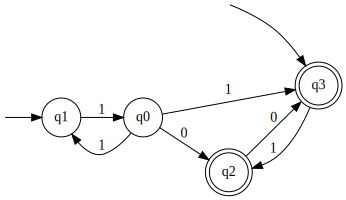

In [18]:
nfa.plot()

In [19]:
nfa.cycle_height()

2

In [20]:
%%time
data = [(i,nfa.bruteforce_count_only(i)) for i in range(1, 21)]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/256 [00:00<?, ?it/s]

  0%|          | 0/512 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/2048 [00:00<?, ?it/s]

  0%|          | 0/4096 [00:00<?, ?it/s]

  0%|          | 0/8192 [00:00<?, ?it/s]

  0%|          | 0/16384 [00:00<?, ?it/s]

  0%|          | 0/32768 [00:00<?, ?it/s]

  0%|          | 0/65536 [00:00<?, ?it/s]

  0%|          | 0/131072 [00:00<?, ?it/s]

  0%|          | 0/262144 [00:00<?, ?it/s]

  0%|          | 0/524288 [00:00<?, ?it/s]

  0%|          | 0/1048576 [00:00<?, ?it/s]

CPU times: user 11.4 s, sys: 0 ns, total: 11.4 s
Wall time: 11.3 s


<AxesSubplot:xlabel='i'>

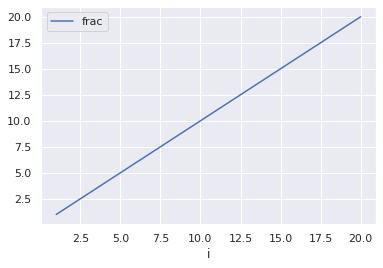

In [21]:
df = pd.DataFrame(data, columns=["i", "frac"])

df.plot(x="i", y="frac")